In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    r2_score, mean_absolute_percentage_error
)
import numpy as np
from sklearn.model_selection import KFold
import optuna
from lightgbm import LGBMRegressor
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('/Users/robertbonnet/Documents/Notebooks/Supplement_Sales_Weekly_Expanded.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4384 entries, 2020-01-06 to 2025-03-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product Name    4384 non-null   object 
 1   Category        4384 non-null   object 
 2   Units Sold      4384 non-null   int64  
 3   Price           4384 non-null   float64
 4   Revenue         4384 non-null   float64
 5   Discount        4384 non-null   float64
 6   Units Returned  4384 non-null   int64  
 7   Location        4384 non-null   object 
 8   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 342.5+ KB


In [4]:
df.head(60)

,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
Date,,,,,,,,,
2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb
2020-01-06,BCAA,Amino Acid,154,41.19,6343.26,0.13,1,UK,Walmart
2020-01-06,Creatine,Performance,134,32.49,4353.66,0.05,1,UK,Walmart
2020-01-06,Zinc,Mineral,147,46.68,6861.96,0.19,0,Canada,Amazon
2020-01-06,Collagen Peptides,Protein,147,10.96,1611.12,0.06,2,USA,Amazon


In [5]:
#Verify the DataTime is in chronological order
print(df.index.is_monotonic_increasing)

True


In [6]:
df.columns = (
    df.columns
    .str.strip()          # Remove leading/trailing whitespace
    .str.lower()          # Convert to lowercase
    .str.replace(' ', '_')# Replace spaces with underscores
    .str.replace(r'[^\w_]', '', regex=True)  # Remove non-alphanumeric characters
)

In [7]:
df['product_name'].unique()

array(['Whey Protein', 'Vitamin C', 'Fish Oil', 'Multivitamin',
       'Pre-Workout', 'BCAA', 'Creatine', 'Zinc', 'Collagen Peptides',
       'Magnesium', 'Ashwagandha', 'Melatonin', 'Biotin',
       'Green Tea Extract', 'Iron Supplement', 'Electrolyte Powder'],
      dtype=object)

# Analysis

<Axes: xlabel='Date'>

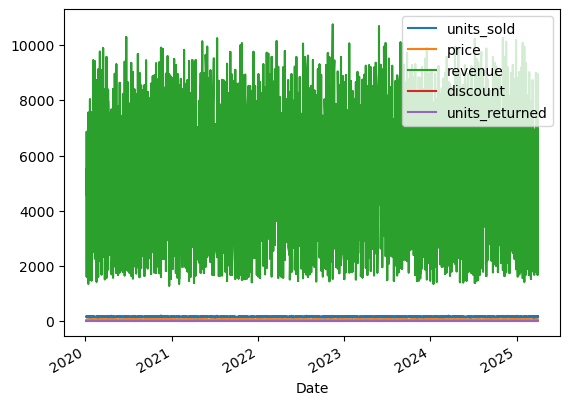

In [8]:
df.plot()

In [9]:
total_sales = df.groupby("product_name")['revenue'].sum().sort_values(ascending=False)

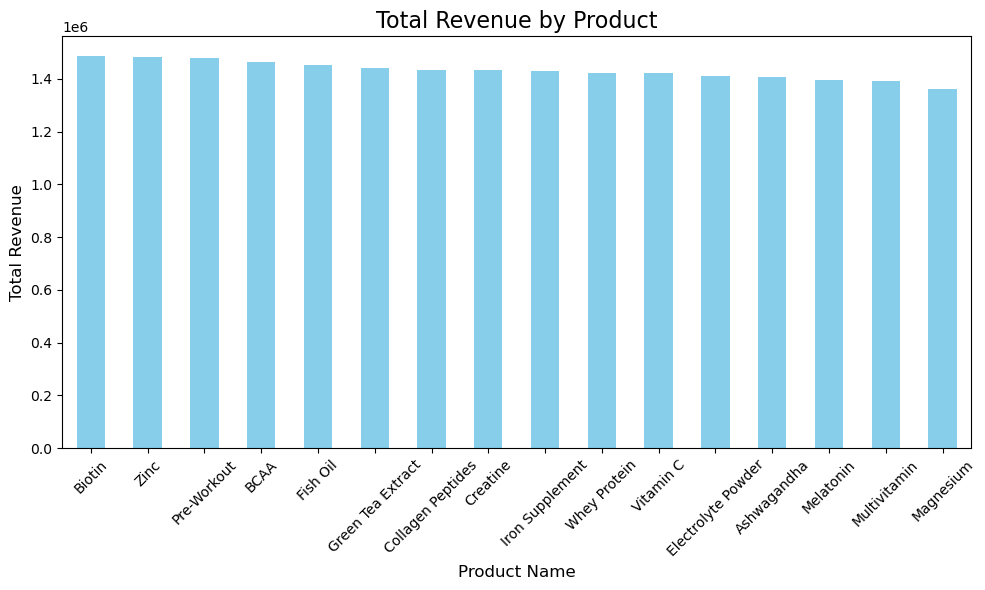

In [10]:
# Plotting the bar chart using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the size of the plot
total_sales.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Total Revenue by Product', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


In [11]:
iherb_total_sales = df[df["platform"]=="iHerb"].groupby("product_name")['revenue'].sum().sort_values(ascending=False)

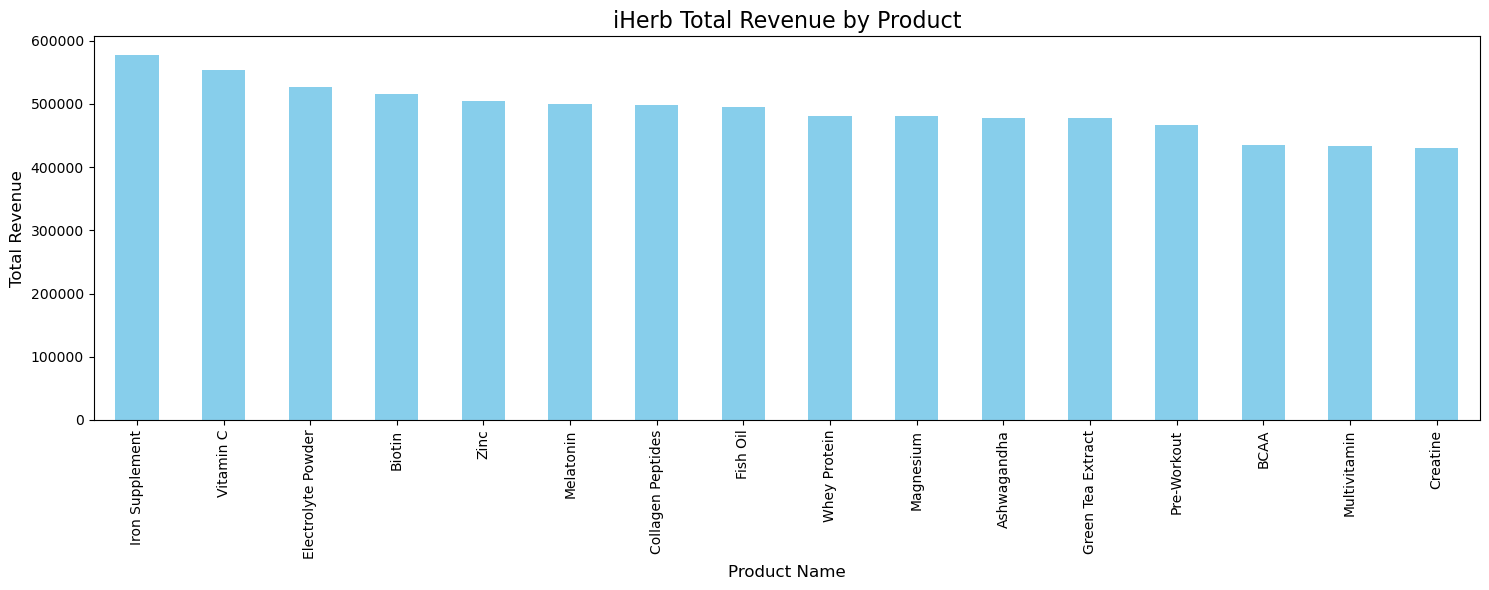

In [12]:
# Plotting the bar chart using Matplotlib
plt.figure(figsize=(15, 6))  # Optional: Set the size of the plot
iherb_total_sales.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('iHerb Total Revenue by Product', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

# Show the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [13]:
last_year_sales = df['2024-04': '2025-03'].groupby("product_name")['revenue'].sum().sort_values(ascending=False)

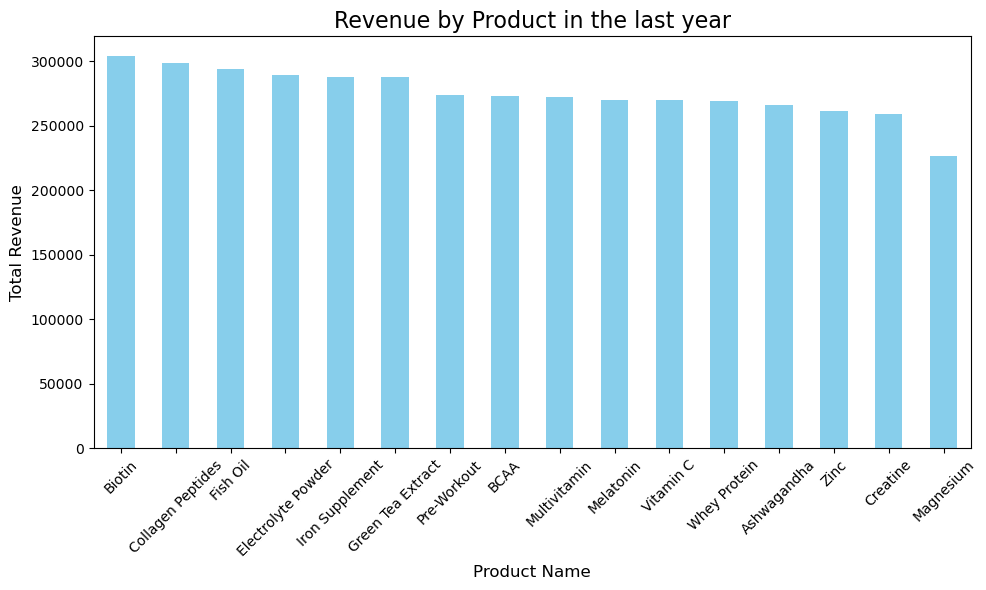

In [14]:
# Plotting the bar chart using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the size of the plot
last_year_sales.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Revenue by Product in the last year', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [15]:
# Filter data for the date range from April 2024 to March 2025 and Platform == 'iHerb'
iherb_last_year_sales = df[(df.index >= '2024-04-01') & (df.index <= '2025-03-31') & (df['platform'] == 'iHerb')]

# Group by Product Name and sum the Revenue, then sort in descending order
iherb_last_year_sales = iherb_last_year_sales.groupby("product_name")['revenue'].sum().sort_values(ascending=False)


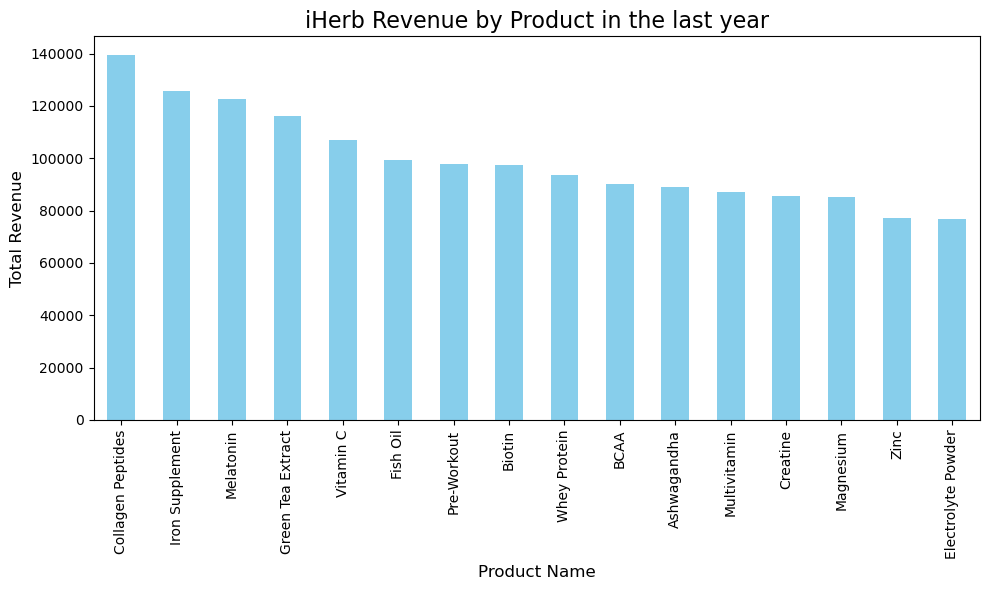

In [16]:
# Plotting the bar chart using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the size of the plot
iherb_last_year_sales.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('iHerb Revenue by Product in the last year', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

# Show the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

# Seasonality and trend study

In [17]:
#Select zinc supplement
market_zinc_revenue = df[df['product_name']=='Zinc']

#Select "Revenue" column
market_zinc_revenue = market_zinc_revenue["revenue"]

#Resample for monthly periods
market_zinc_revenue = market_zinc_revenue.resample('M').sum()


/var/folders/rd/tgzdftq167g5kmmj_jjf8r8c0000gn/T/ipykernel_66094/238963244.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_zinc_revenue = market_zinc_revenue.resample('M').sum()


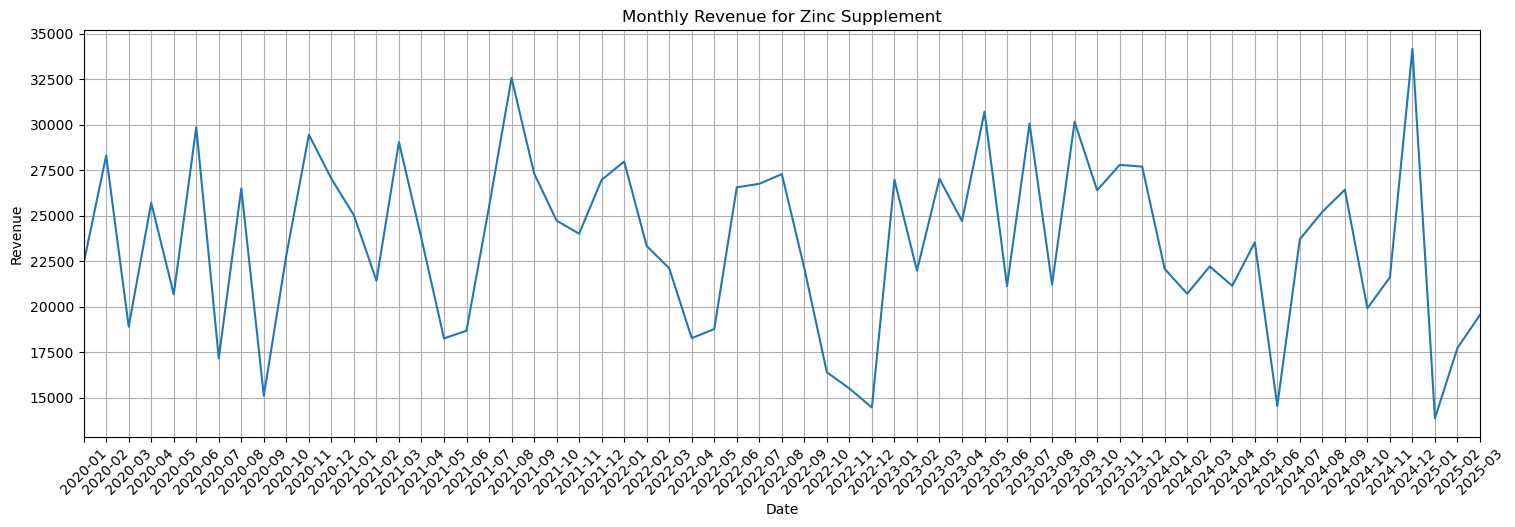

In [18]:
market_zinc_revenue.plot(figsize=(15, 5), title="Monthly Revenue for Zinc Supplement")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
ticks = market_zinc_revenue.index #Selcet labels period for X axis
labels = ticks.strftime('%Y-%m') #Select labels for X axis to include date and hour
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.show()

In [19]:
#Select iHerb sales
iherb_zinc_revenue = df[df['platform']=='iHerb']

#Select zinc supplement
iherb_zinc_revenue = iherb_zinc_revenue[iherb_zinc_revenue['product_name']=='Zinc']

#Select "Revenue" column
iherb_zinc_revenue = iherb_zinc_revenue["revenue"]

#Resample for monthly periods
iherb_zinc_revenue = iherb_zinc_revenue.resample('M').sum()


/var/folders/rd/tgzdftq167g5kmmj_jjf8r8c0000gn/T/ipykernel_66094/3729650915.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  iherb_zinc_revenue = iherb_zinc_revenue.resample('M').sum()


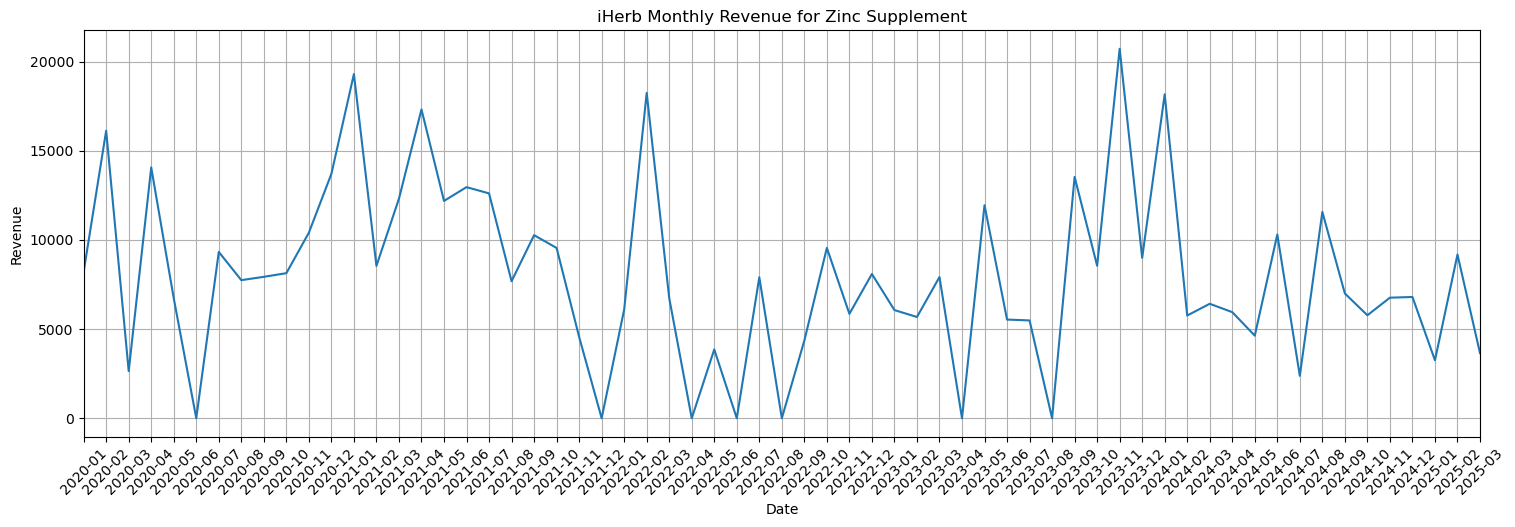

In [20]:
iherb_zinc_revenue.plot(figsize=(15, 5), title="iHerb Monthly Revenue for Zinc Supplement")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
ticks = iherb_zinc_revenue.index #Selcet labels period for X axis
labels = ticks.strftime('%Y-%m') #Select labels for X axis to include date and hour
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.show()

In [21]:
market_zinc_decomposed = seasonal_decompose(market_zinc_revenue, period=12, model='additive')

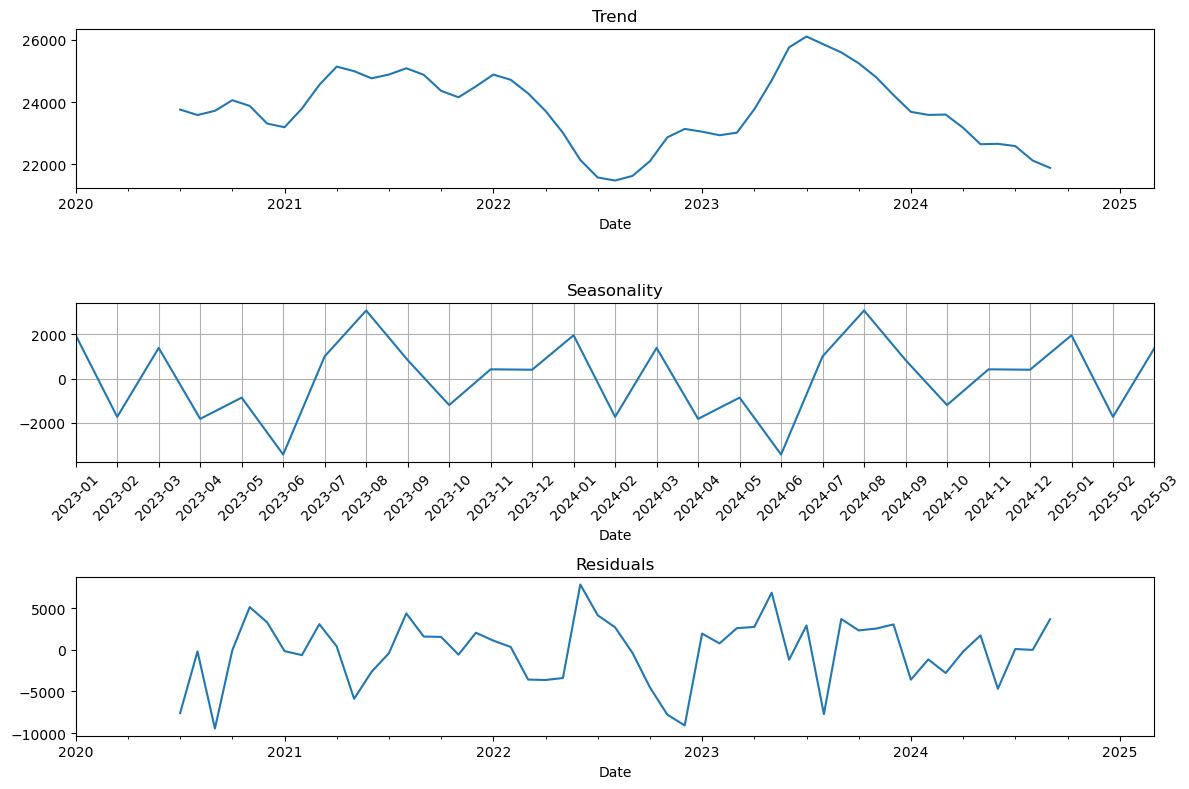

In [22]:
#Analysis of trend and seasonality
plt.figure(figsize=(12, 8))

plt.subplot(311)
market_zinc_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
market_zinc_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)  # Add a grid
plt.xlim(('2023', '2025')) #Select Time window
ticks = market_zinc_revenue.loc['2023':'2025'].index #Selcet labels period for X axis
labels = ticks.strftime('%Y-%m') #Select labels for X axis to include date and hour
plt.xticks(ticks=ticks, labels=labels, rotation=45)


plt.subplot(313)
market_zinc_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

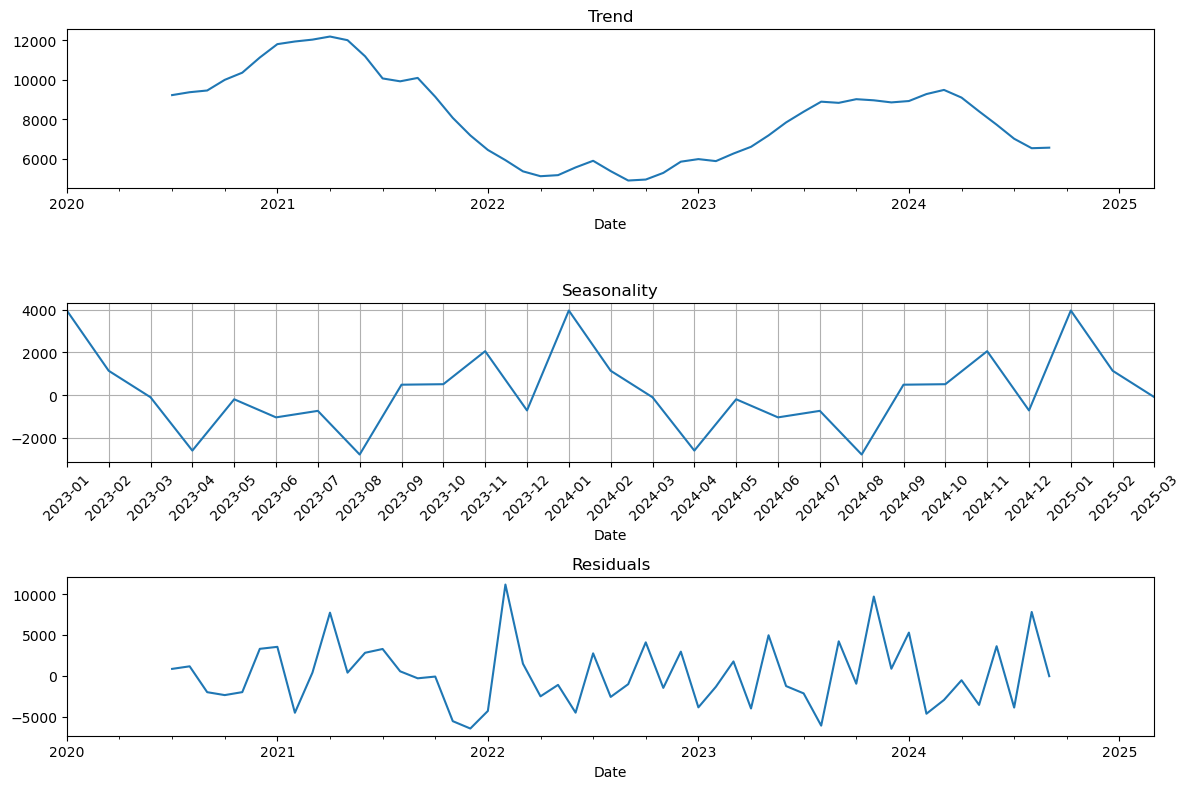

In [23]:
iherb_zinc_decomposed = seasonal_decompose(iherb_zinc_revenue, period=12, model='additive')
#Analysis of trend and seasonality
plt.figure(figsize=(12, 8))

plt.subplot(311)
iherb_zinc_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
iherb_zinc_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)  # Add a grid
plt.xlim(('2023', '2025')) #Select Time window
ticks = iherb_zinc_revenue.loc['2023':'2025'].index #Selcet labels period for X axis
labels = ticks.strftime('%Y-%m') #Select labels for X axis to include date and hour
plt.xticks(ticks=ticks, labels=labels, rotation=45)


plt.subplot(313)
iherb_zinc_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

# Time Series Split

In [24]:
#Select zinc supplement
market_zinc = df[df['product_name']=='Zinc']

#Select "Revenue" column
market_zinc_revenue = market_zinc["revenue"]
market_zinc_price = market_zinc["price"]
market_zinc_discount = market_zinc["discount"]

#Resample for monthly periods
market_zinc_revenue = market_zinc_revenue.resample('M').sum()
market_zinc_price = market_zinc_price.resample('M').mean()
market_zinc_discount = market_zinc_discount.resample('M').mean()

ml_df = pd.concat([market_zinc_revenue, market_zinc_price], axis=1)
ml_df = pd.concat([ml_df, market_zinc_discount], axis=1)

/var/folders/rd/tgzdftq167g5kmmj_jjf8r8c0000gn/T/ipykernel_66094/2193535552.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_zinc_revenue = market_zinc_revenue.resample('M').sum()
/var/folders/rd/tgzdftq167g5kmmj_jjf8r8c0000gn/T/ipykernel_66094/2193535552.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_zinc_price = market_zinc_price.resample('M').mean()
/var/folders/rd/tgzdftq167g5kmmj_jjf8r8c0000gn/T/ipykernel_66094/2193535552.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_zinc_discount = market_zinc_discount.resample('M').mean()


In [25]:
def timeseries_cross_validation(model, X, y, k_folds=5):
    """
    Evaluates a model with K-fold Cross Validation and calculates metrics.

    Parameters:
    model: A Scikit-Learn or compatible machine learning model.
    X: The dataset characteristics.
    y: The target or label of the dataset.
    k_folds: Number of folds in K-fold cross-validation.

    Returns:
    dict: A dictionary containing the model's performance metrics including R² for each fold.
    """

    # Initialize the TimeSeriesSplit object for time series cross-validation
    cv = TimeSeriesSplit(n_splits=k_folds)

    # Initialize variables to store metrics
    mean_absolute_error_metric = []
    mean_squared_error_metric = []
    root_mean_squared_error_metric = []
    mean_absolute_percentage_error_metric = []
    r2_metric = []  # Will store R² for each fold

    # Cross-validation loop
    for train_index, valid_index in cv.split(X, y):
        # Split the data into training and validation sets
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_valid)
        
        # Calculate metrics
        mean_absolute_error_metric.append(mean_absolute_error(y_valid, y_pred))
        mean_squared_error_metric.append(mean_squared_error(y_valid, y_pred))
        root_mean_squared_error_metric.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
        mean_absolute_percentage_error_metric.append(np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100)
        r2_metric.append(r2_score(y_valid, y_pred))  # Store R² for each fold
    
    # Instead of averaging R², just return the list of R² scores for each fold
    return {
        'r2_for_each_fold': r2_metric,
        'avg_mae': np.mean(mean_absolute_error_metric),
        'avg_mse': np.mean(mean_squared_error_metric),
        'avg_rmse': np.mean(root_mean_squared_error_metric),
        'avg_mape': np.mean(mean_absolute_percentage_error_metric),
    }


# Feature engineering

In [26]:
def make_features(data, max_lag=1, rolling_mean_size=1):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofmonth'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['revenue'].shift(lag)

    data['rolling_mean'] = (
        data['revenue'].shift().rolling(rolling_mean_size).mean()
    )
    data['revenue_shift_dif'] = data['revenue'].shift(1) - data['revenue'].shift(2)

In [27]:
ml_df

,revenue,price,discount
Date,,,
2020-01-31,22370.88,38.0525,0.1625
2020-02-29,28298.68,42.6525,0.0975
2020-03-31,18895.19,25.9940,0.0720
2020-04-30,25698.75,39.9700,0.1775
2020-05-31,20674.01,33.4975,0.0875
...,...,...,...
2024-11-30,21604.92,35.5625,0.0550
2024-12-31,34161.96,46.4080,0.1240
2025-01-31,13863.36,23.8125,0.1300


In [28]:
#Create new features with a 24-h period for the lag and rolling size since this is the window of seasonality
make_features(ml_df)

In [48]:
#Drop NaN values which were created before the lag and rolling size window
ml_df = ml_df.dropna()

In [30]:
ml_df

,revenue,price,discount,month,dayofmonth,dayofweek,lag_1,rolling_mean,revenue_shift_dif
Date,,,,,,,,,
2020-03-31,18895.19,25.9940,0.0720,3,31,1,28298.68,28298.68,5927.80
2020-04-30,25698.75,39.9700,0.1775,4,30,3,18895.19,18895.19,-9403.49
2020-05-31,20674.01,33.4975,0.0875,5,31,6,25698.75,25698.75,6803.56
2020-06-30,29856.62,41.3080,0.0960,6,30,1,20674.01,20674.01,-5024.74
2020-07-31,17160.42,29.1725,0.1300,7,31,4,29856.62,29856.62,9182.61
...,...,...,...,...,...,...,...,...,...
2024-11-30,21604.92,35.5625,0.0550,11,30,5,19907.34,19907.34,-6511.25
2024-12-31,34161.96,46.4080,0.1240,12,31,1,21604.92,21604.92,1697.58
2025-01-31,13863.36,23.8125,0.1300,1,31,4,34161.96,34161.96,12557.04


In [31]:
X = ml_df.drop(['revenue'], axis=1)
y = ml_df['revenue']

In [32]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale, columns=X.columns)

In [33]:
X_scale

,price,discount,month,dayofmonth,dayofweek,lag_1,rolling_mean,revenue_shift_dif
0,-1.450377,-1.534299,-0.997178,0.679457,-0.953966,0.991820,0.991820,0.913301
1,0.566452,1.371095,-0.707521,-0.539569,0.040768,-1.000299,-1.000299,-1.418855
2,-0.367573,-1.107440,-0.417865,0.679457,1.532869,0.441028,0.441028,1.046519
3,0.759534,-0.873356,-0.128209,-0.539569,-0.953966,-0.623458,-0.623458,-0.752771
4,-0.991699,0.062979,0.161448,0.679457,0.538135,1.321868,1.321868,1.408414
...,...,...,...,...,...,...,...,...
56,-0.069579,-2.002467,1.320073,-0.539569,1.035502,-0.785876,-0.785876,-0.978895
57,1.495498,-0.102257,1.609729,0.679457,-0.953966,-0.426246,-0.426246,0.269811
58,-1.765182,0.062979,-1.576490,0.679457,0.538135,2.233949,2.233949,1.921723
59,-1.285362,1.026854,-1.286834,-2.977619,0.538135,-2.066287,-2.066287,-3.076191


# Train and test split

In [34]:
#Split main DF into train and test subsets
train_df, test_df = train_test_split(ml_df, shuffle=False, test_size=0.2)
#Shuffling is avoided since chronological order will be kept and the test size is the 20% of the DF

In [35]:
#Split features and target from train and test Dfs
train_features = train_df.drop(['revenue'], axis=1)
train_target = train_df['revenue']
test_features = test_df.drop(['revenue'], axis=1)
test_target = test_df['revenue']

In [36]:
train_scaler = StandardScaler()
X_train_scale = train_scaler.fit_transform(train_features)
X_train_scale = pd.DataFrame(X_train_scale, columns=train_features.columns)

X_test_scale = train_scaler.transform(test_features)
X_test_scale = pd.DataFrame(X_test_scale, columns=test_features.columns)

# Linear Regression Model

In [37]:
#Train a linear regression model
lr_model = LinearRegression()

In [38]:
timeseries_cross_validation(lr_model, X_scale, y, k_folds=5)

{'r2_for_each_fold': [0.35137830051741203,
  0.4566791955005651,
  0.8420634405695552,
  0.7713748959027293,
  0.8277505177063968],
 'avg_mae': 2085.3679245795274,
 'avg_mse': 6212947.739842467,
 'avg_rmse': 2421.112528888246,
 'avg_mape': 9.272003561008342}

In [39]:
lr_model.fit(X_train_scale, train_target)

LinearRegression()

# Test

In [40]:
#LR SLinding Cross Validation
cv = SlidingWindowSplitter(step_length=1, fh=1, window_length=50)

# Initialize a list to store R2 scores for each fold
answers = []
predictions = []
r2_scores = []

#X = ml_df.drop('revenue', axis=1)
y = ml_df['revenue']

X = X_scale

# Loop over the TimeSeriesSplit splits
for train_index, valid_index in cv.split(ml_df):
    # Create training and validation datasets
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    #Initialize the model
    lr_model = LinearRegression()

    # Train the model
    lr_model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_hat = lr_model.predict(X_valid)

    #answer = valid_data.values[0, 0]
    answers.append(y_valid)

    #prediction = y_hat_df['NBEATS'].values[0]
    predictions.append(y_hat)

    print("Train X index:", X_train.index)
    print("Valid X index:", X_valid.index)

    mean_pred = y_train.mean()
    print("Mean prediction", mean_pred)
    #print("Median prediction", train_data.values[:, 0].median())
    print("Previous prediction", y_train.iloc[-1])

    #print("Prediction Shape:", prediction.shape)
    print("Model prediction:", y_hat)
    #print("Answer Shape:", answer.shape)
    print("Answer:", y_valid)

print("R2 score:", r2_score(answers, predictions))

Train X index: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype='int64')
Valid X index: Index([50], dtype='int64')
Mean prediction 23833.808399999998
Previous prediction 21138.73
Model prediction: [24373.98343048]
Answer: Date
2024-05-31    23524.16
Freq: ME, Name: revenue, dtype: float64
Train X index: Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype='int64')
Valid X index: Index([51], dtype='int64')
Mean prediction 23926.387799999997
Previous prediction 23524.16
Model prediction: [11747.64866217]
Answer: Date
2024-06-30    14533.32
Freq: ME, Name: revenue, dtype: float64
Train X index: Index([ 2,  3,  4,  5,  6,  7,  8, 

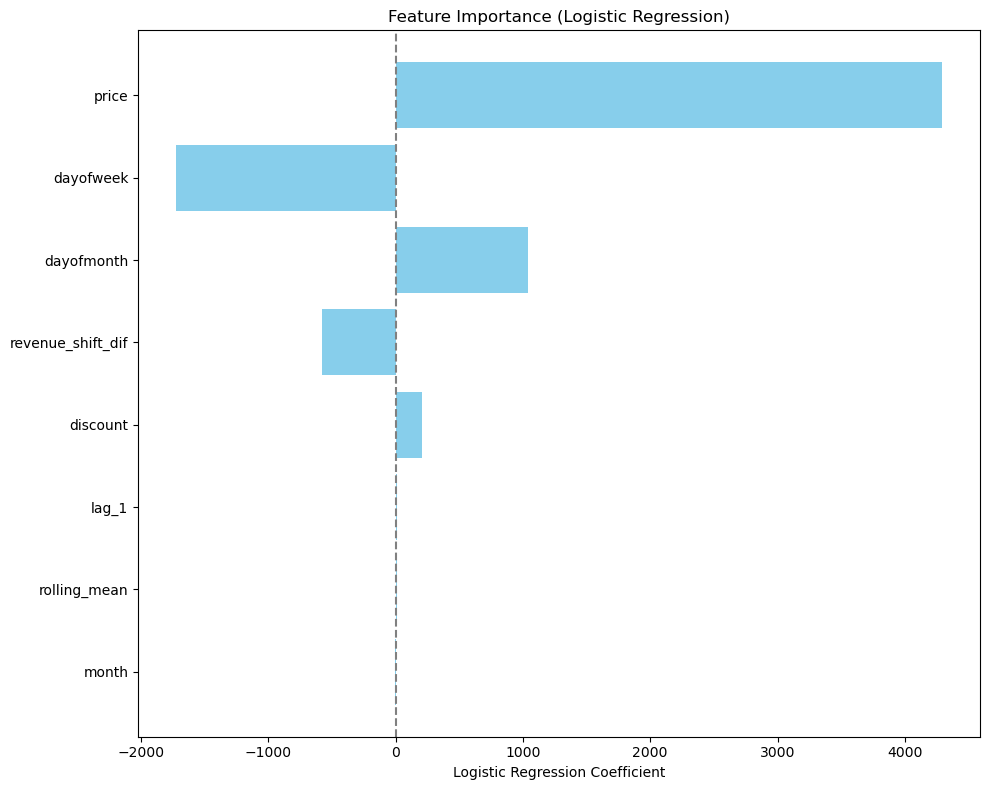

In [ ]:
# Get the coefficients
coefficients = lr_model.coef_  # shape: (n_features,)

# Get feature names
feature_names = X_scale.columns  # or scaled_X_train.columns if you're using scaled data

# Create a pandas Series for easy sorting and labeling
coef_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by absolute value (most important at the bottom)
sorted_coef = coef_series.reindex(coef_series.abs().sort_values().index)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_coef.index, sorted_coef.values, color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')  # optional: vertical line at 0
plt.xlabel("Logistic Regression Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.tight_layout()
plt.show()

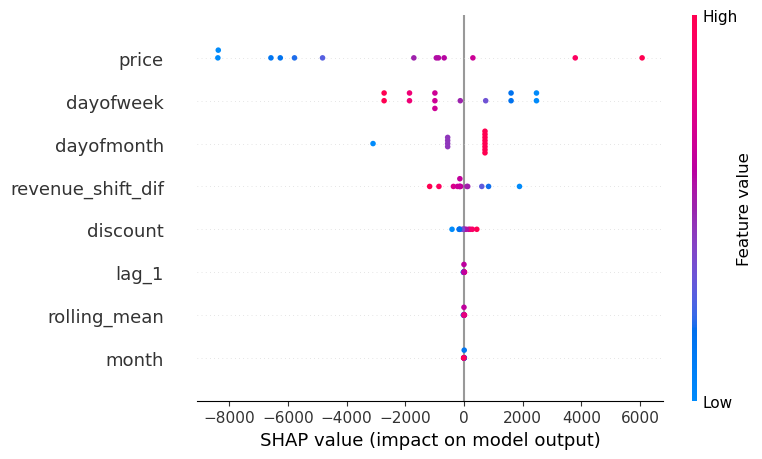

In [42]:
# Create the SHAP explainer object
lr_explainer = shap.LinearExplainer(lr_model, X_train_scale)

# Calculate SHAP values for the test set
lr_shap_values = lr_explainer.shap_values(X_test_scale)

# Summary plot for all test samples
shap.summary_plot(lr_shap_values, X_test_scale)